In [1]:
import sys
sys.path.insert(0, '..')
from qoop.compilation.qsp import QuantumStatePreparation
from qoop.core import state, ansatz
from qoop.compilation import compress
import numpy as np
import matplotlib.pyplot as plt
import cv2
%load_ext autoreload
%autoreload 2

In [23]:
# read lenna and resize at 28 x 28 and save it
img = cv2.imread('../images/lenna.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (8, 8))
cv2.imwrite('../images/lenna_8x8.png', img)

True

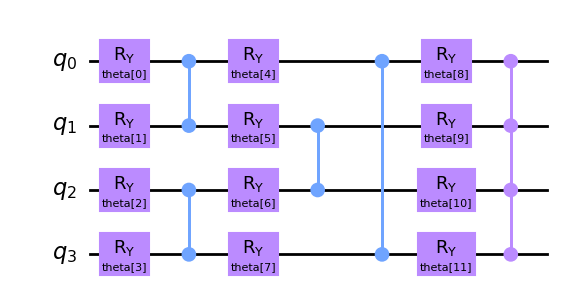

In [19]:
ansatz.g2gn(4, 1).draw('mpl')

In [7]:
# Read image lenna.png by cv2 and convert it to grayscale (matrix of 0 - 1 values
# where 0 is black and 1 is white)
img = cv2.imread('../images/lenna_8x8.png', cv2.IMREAD_GRAYSCALE) / 255
def compress_img(img, k):
    img = np.array(img)
    num_qubits = int(np.log2(k**2))
    blocks, scales = compress.divide_image(img, k)
    params = []
    for i in range(0, len(blocks)):
        num_layers = 2
        qsp = QuantumStatePreparation(
            u=ansatz.g2gn(num_qubits, num_layers),
            target_state=state.specific(blocks[i]).inverse(),
        ).fit()
        params.append(qsp.compiler.thetas)
    return params, scales

def decompress_img(params, scales, k):
    import qiskit.quantum_info as qi
    num_qubits = int(np.log2(k**2))
    blocks = []
    num_layers = 2
    for i in range(0, len(params)):
        qc1 = ansatz.g2gn(num_qubits, num_layers).assign_parameters(params[i])
        block = (qi.Statevector.from_instruction(qc1).data) * scales[i]
        blocks.append(block)
    blocks = np.array(blocks)
    blocks = blocks.reshape(int(img.shape[0]/k), int(img.shape[1]/k), -1)
    print(blocks.shape)
    reconstructed_img = np.zeros((img.shape[0], img.shape[1]))
    for i in range(0, int(img.shape[0]/k)):
        for j in range(0, int(img.shape[1]/k)):
            reconstructed_img[i*k:(i+1)*k, j*k:(j+1)*k] = blocks[i, j].reshape(k, k)
    return (-reconstructed_img)

In [5]:
params, scales = compress_img(img, 2)

In [8]:
image = decompress_img(params, scales, 2)

(4, 4, 4)


/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_19589/170051002.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructed_img[i*k:(i+1)*k, j*k:(j+1)*k] = blocks[i, j].reshape(k, k)


In [38]:
img = cv2.imread('../images/lenna_8x8.png', cv2.IMREAD_GRAYSCALE) / 255
img = np.array(img)
print(img)

[[0.69411765 0.4627451  0.56078431 0.54117647 0.53333333 0.65098039
  0.57647059 0.43529412]
 [0.62352941 0.45882353 0.50588235 0.62352941 0.81176471 0.63137255
  0.61568627 0.25882353]
 [0.63137255 0.44705882 0.48235294 0.65882353 0.69803922 0.76078431
  0.20784314 0.64313725]
 [0.60392157 0.45098039 0.52941176 0.23921569 0.69411765 0.21960784
  0.25882353 0.63137255]
 [0.58039216 0.4627451  0.51764706 0.37647059 0.57647059 0.28235294
  0.63137255 0.69803922]
 [0.61568627 0.20784314 0.83921569 0.34901961 0.48235294 0.32156863
  0.58039216 0.81960784]
 [0.4627451  0.21960784 0.45490196 0.31372549 0.63137255 0.5372549
  0.52941176 0.41960784]
 [0.4        0.2745098  0.53333333 0.39607843 0.58823529 0.80392157
  0.21960784 0.34117647]]


In [9]:
# calculate SSIM between original image and reconstructed image
import skimage.metrics as metrics
ssim = metrics.structural_similarity(img, image)
print(ssim)

0.9999999997584612


In [8]:
num_qubits = 3
num_layers = 2
qsp = QuantumStatePreparation(
    u=ansatz.g2gn(num_qubits, num_layers),
    target_state=state.haar(3).inverse(),
).fit()